In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/ada_multigrid_ppo')

In [2]:
%matplotlib notebook
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
from copy import copy, deepcopy

import gym
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList
from utils.custom_eval_callback import CustomEvalCallback, CustomEvalCallbackParallel
from utils.env_wrappers import StateCoarse, BufferWrapper, EnvCoarseWrapper, StateCoarseMultiGrid
from typing import Callable
from utils.plot_functions import plot_learning
from utils.multigrid_framework_functions import env_wrappers_multigrid, make_env, generate_beta_environement, parallalize_env, multigrid_framework

from model.ressim import Grid
from ressim_env import ResSimEnv_v0, ResSimEnv_v1

/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ad181/anaconda3/lib/python3.7/site-packages/tensorboard/co

In [3]:
seed=1
case='case_2_singlegrid_quarter'
data_dir='./data'
log_dir='./data/'+case

In [4]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

In [5]:
with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env_train = pickle.load(input)

# define RL model and callbacks

In [6]:
def generate_model(env_train, seed):
    dummy_env =  generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    dummy_env_parallel = parallalize_env(dummy_env, num_actor=64, seed=seed)
    model = PPO(policy=MlpPolicy,
                env=dummy_env_parallel,
                learning_rate = 1e-4,
                n_steps = 40,
                batch_size = 16,
                n_epochs = 20,
                gamma = 0.99,
                gae_lambda = 0.95,
                clip_range = 0.15,
                clip_range_vf = None,
                ent_coef = 0.001,
                vf_coef = 0.5,
                max_grad_norm = 0.5,
                use_sde= False,
                create_eval_env= False,
                policy_kwargs = dict(net_arch=[70,70,50], log_std_init=-1.7),
                verbose = 1,
                target_kl =0.1,
                seed = seed,
                device = "auto")
    return model

def generate_callback(env_train, best_model_save_path, log_path, eval_freq):
    dummy_env = generate_beta_environement(env_train, 0.5, env_train.p_x, env_train.p_y, seed)
    callback = CustomEvalCallbackParallel(dummy_env, 
                                          best_model_save_path=best_model_save_path, 
                                          n_eval_episodes=1,
                                          log_path=log_path, 
                                          eval_freq=eval_freq)
    return callback

# multigrid framework

/data/ad181/RemoteDir/ada_multigrid_ppo/utils/coarse_grid_functions.py:51: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for j in range(len(p_1)-1):


Using cuda device
seed 1: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fd63c3d3ef0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fd63b392f28>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------
| eval/              |          |
|    mean_ep_length  | 5        |
|    mean_reward     | 0.679    |
| time/              |          |
|    fps             | 135      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 2560     |
---------------------------------
policy iteration runtime: 46 seconds

Total episode rollouts: 512

Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.679     |
| time/                   |           |
|    fps                  | 777       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|  

policy iteration runtime: 43 seconds

Total episode rollouts: 4608

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.717    |
| time/                   |          |
|    fps                  | 753      |
|    iterations           | 1        |
|    time_elapsed         | 3        |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.049085 |
|    clip_fraction        | 0.493    |
|    clip_range           | 0.15     |
|    entropy_loss         | 6.11     |
|    explained_variance   | 0.961    |
|    learning_rate        | 0.0001   |
|    loss                 | -0.0788  |
|    n_updates            | 180      |
|    policy_gradient_loss | -0.0467  |
|    std                  | 0.181    |
|    value_loss           | 0.00163  |
-------

policy iteration runtime: 37 seconds

Total episode rollouts: 8704

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.745      |
| time/                   |            |
|    fps                  | 757        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.05409802 |
|    clip_fraction        | 0.51       |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.46       |
|    explained_variance   | 0.965      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0583    |
|    n_updates            | 340        |
|    policy_gradient_loss | -0.045     |
|    std                  | 0.178      |
|    v

policy iteration runtime: 33 seconds

Total episode rollouts: 12800

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.771      |
| time/                   |            |
|    fps                  | 737        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07528596 |
|    clip_fraction        | 0.558      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.65       |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0489    |
|    n_updates            | 500        |
|    policy_gradient_loss | -0.0427    |
|    std                  | 0.177      |
|    

policy iteration runtime: 38 seconds

Total episode rollouts: 16896

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.777       |
| time/                   |             |
|    fps                  | 757         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.065170564 |
|    clip_fraction        | 0.575       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.96        |
|    explained_variance   | 0.971       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.065      |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0417     |
|    std                  | 0.174       |
|    va

policy iteration runtime: 44 seconds

Total episode rollouts: 20992

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.791      |
| time/                   |            |
|    fps                  | 726        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06294056 |
|    clip_fraction        | 0.579      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.45       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0117    |
|    n_updates            | 820        |
|    policy_gradient_loss | -0.0348    |
|    std                  | 0.17       |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 25088

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.798      |
| time/                   |            |
|    fps                  | 759        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07259835 |
|    clip_fraction        | 0.587      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.09       |
|    explained_variance   | 0.974      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0453    |
|    n_updates            | 980        |
|    policy_gradient_loss | -0.0353    |
|    std                  | 0.165      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 29184

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.808       |
| time/                   |             |
|    fps                  | 759         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.068703726 |
|    clip_fraction        | 0.597       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.94        |
|    explained_variance   | 0.98        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0173     |
|    n_updates            | 1140        |
|    policy_gradient_loss | -0.0325     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 33280

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07281404 |
|    clip_fraction        | 0.6        |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.56       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0728    |
|    n_updates            | 1300       |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.155      |
|    

policy iteration runtime: 30 seconds

Total episode rollouts: 37376

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.82        |
| time/                   |             |
|    fps                  | 757         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.091239884 |
|    clip_fraction        | 0.613       |
|    clip_range           | 0.15        |
|    entropy_loss         | 10.2        |
|    explained_variance   | 0.984       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0114     |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.0285     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 41472

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.823      |
| time/                   |            |
|    fps                  | 758        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06918831 |
|    clip_fraction        | 0.619      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.8       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0685    |
|    n_updates            | 1620       |
|    policy_gradient_loss | -0.0257    |
|    std                  | 0.146      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 45568

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.824      |
| time/                   |            |
|    fps                  | 744        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09592082 |
|    clip_fraction        | 0.622      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.3       |
|    explained_variance   | 0.985      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0407    |
|    n_updates            | 1780       |
|    policy_gradient_loss | -0.0238    |
|    std                  | 0.143      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 49664

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 778        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08383379 |
|    clip_fraction        | 0.628      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.6       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0279    |
|    n_updates            | 1940       |
|    policy_gradient_loss | -0.0241    |
|    std                  | 0.142      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 53760

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.826       |
| time/                   |             |
|    fps                  | 772         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.095518105 |
|    clip_fraction        | 0.633       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.9        |
|    explained_variance   | 0.987       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0556     |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.0192     |
|    std                  | 0.14        |
|    va

policy iteration runtime: 36 seconds

Total episode rollouts: 57856

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.828       |
| time/                   |             |
|    fps                  | 799         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.091054276 |
|    clip_fraction        | 0.624       |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.3        |
|    explained_variance   | 0.988       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00726     |
|    n_updates            | 2260        |
|    policy_gradient_loss | -0.0152     |
|    std                  | 0.137       |
|    va

policy iteration runtime: 34 seconds

Total episode rollouts: 61952

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 771        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10346468 |
|    clip_fraction        | 0.638      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0454    |
|    n_updates            | 2420       |
|    policy_gradient_loss | -0.0184    |
|    std                  | 0.135      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 66048

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 799        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10380657 |
|    clip_fraction        | 0.637      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13         |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0385    |
|    n_updates            | 2580       |
|    policy_gradient_loss | -0.0142    |
|    std                  | 0.133      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 70144

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 783        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10884969 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.4       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00806    |
|    n_updates            | 2740       |
|    policy_gradient_loss | -0.0155    |
|    std                  | 0.13       |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 74240

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 780        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09040365 |
|    clip_fraction        | 0.644      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.7       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0444    |
|    n_updates            | 2900       |
|    policy_gradient_loss | -0.0162    |
|    std                  | 0.128      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 78336

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.831     |
| time/                   |           |
|    fps                  | 775       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1072333 |
|    clip_fraction        | 0.637     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14        |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.0001    |
|    loss                 | 0.0297    |
|    n_updates            | 3060      |
|    policy_gradient_loss | -0.0166   |
|    std                  | 0.127     |
|    value_loss           | 0.000577  |
-------

policy iteration runtime: 32 seconds

Total episode rollouts: 82432

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 785        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12518862 |
|    clip_fraction        | 0.651      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.4       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.144      |
|    n_updates            | 3220       |
|    policy_gradient_loss | -0.0131    |
|    std                  | 0.124      |
|    value_loss           |

policy iteration runtime: 45 seconds

Total episode rollouts: 86528

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14007315 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0559    |
|    n_updates            | 3380       |
|    policy_gradient_loss | -0.0129    |
|    std                  | 0.124      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 90624

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.832     |
| time/                   |           |
|    fps                  | 788       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1370615 |
|    clip_fraction        | 0.653     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.7      |
|    explained_variance   | 0.99      |
|    learning_rate        | 0.0001    |
|    loss                 | -0.015    |
|    n_updates            | 3540      |
|    policy_gradient_loss | -0.0151   |
|    std                  | 0.122     |
|    value_loss          

policy iteration runtime: 33 seconds

Total episode rollouts: 94720

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 798        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11865959 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0377    |
|    n_updates            | 3700       |
|    policy_gradient_loss | -0.00992   |
|    std                  | 0.121      |
|    value_loss           |

policy iteration runtime: 29 seconds

Total episode rollouts: 98816

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 828        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12983152 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.2       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0598    |
|    n_updates            | 3860       |
|    policy_gradient_loss | -0.0138    |
|    std                  | 0.12       |
|    value_loss           |

Early stopping at step 16 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 102912

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 814        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15888612 |
|    clip_fraction        | 0.655      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0845     |
|    n_updates            | 4020       |
|    policy_gradient_loss | -0.006     |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 32 seconds

Total episode rollouts: 107008

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15381068 |
|    clip_fraction        | 0.677      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0499     |
|    n_updates            | 4180       |
|    policy_gradient_loss | -0.

policy iteration runtime: 33 seconds

Total episode rollouts: 111104

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 784        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13833185 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0109     |
|    n_updates            | 4340       |
|    policy_gradient_loss | -0.0114    |
|    std                  | 0.118      |
|    value_loss           

policy iteration runtime: 32 seconds

Total episode rollouts: 115200

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 787        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13712339 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0808    |
|    n_updates            | 4500       |
|    policy_gradient_loss | -0.00935   |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 119296

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 822        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15287086 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0177    |
|    n_updates            | 4660       |
|    policy_gradient_loss | -0.0047    |
|    std    

Early stopping at step 12 due to reaching max kl: 0.16
policy iteration runtime: 24 seconds

Total episode rollouts: 123392

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 817        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15516488 |
|    clip_fraction        | 0.651      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0648    |
|    n_updates            | 4820       |
|    policy_gradient_loss | -3.39e-05  |
|    std    

Early stopping at step 9 due to reaching max kl: 0.15
policy iteration runtime: 15 seconds

Total episode rollouts: 127488

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 808        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15057847 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00627   |
|    n_updates            | 4980       |
|    policy_gradient_loss | 0.00

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 40 seconds

Total episode rollouts: 131584

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 778        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15173951 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0561    |
|    n_updates            | 5140       |
|    policy_gradient_loss | -0.00403   |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 34 seconds

Total episode rollouts: 135680

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 779        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15160497 |
|    clip_fraction        | 0.681      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0292    |
|    n_updates            | 5300       |
|    policy_gradient_loss | -0.00335   |
|    std    

Early stopping at step 15 due to reaching max kl: 0.16
policy iteration runtime: 32 seconds

Total episode rollouts: 139776

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 754        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15752418 |
|    clip_fraction        | 0.667      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0145     |
|    n_updates            | 5460       |
|    policy_gradient_loss | -0.00309   |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 143872

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 792        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15258761 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0327     |
|    n_updates            | 5620       |
|    policy_gradient_loss | -0.00209   |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 40 seconds

Total episode rollouts: 147968

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.834     |
| time/                   |           |
|    fps                  | 775       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1546841 |
|    clip_fraction        | 0.682     |
|    clip_range           | 0.15      |
|    entropy_loss         | 16.1      |
|    explained_variance   | 0.992     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.038    |
|    n_updates            | 5780      |
|    policy_gradient_loss | -0.00638  |
|    std                  | 0.1

<IPython.core.display.Javascript object>


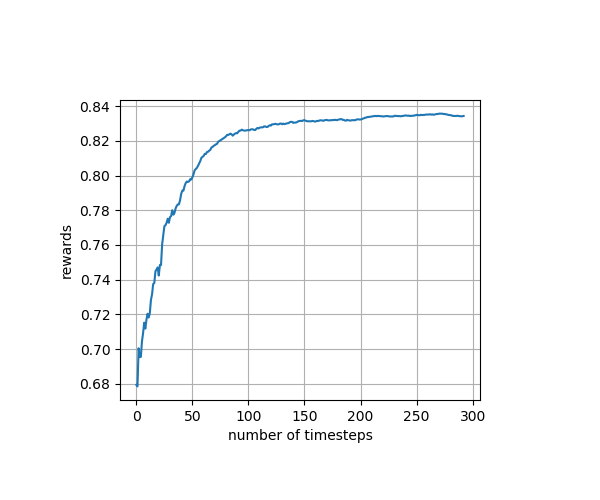

Using cuda device
seed 2: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fd63b678400> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fd63b2cfd68>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.67 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.671      |
| time/                   |            |
|    fps                  | 140        |
|    iterations           | 1          |
|    time_elapsed         | 18         |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15800568 |
|    clip_fraction        | 0.673      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0297    |
|    n_updates            | 5860       |
|    policy_gradient_loss | -0.00517   |
|    std                  | 0.115      |
|    value_loss           | 0.000512   |
---------------------------------

policy iteration runtime: 36 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.72 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.723      |
| time/                   |            |
|    fps                  | 700        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04004362 |
|    clip_fraction        | 0.484      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.07       |
|    explained_variance   | 0.956      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0714    |
|    n_updates            | 160        |
|    policy_gradient_loss | -0.0459    |
|    std                  | 0.181      |
|    v

policy iteration runtime: 37 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.731       |
| time/                   |             |
|    fps                  | 744         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.056324076 |
|    clip_fraction        | 0.51        |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.3         |
|    explained_variance   | 0.967       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0171     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0445     |
|    std                  | 0.179       |
|    val

policy iteration runtime: 34 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.742       |
| time/                   |             |
|    fps                  | 709         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.051982533 |
|    clip_fraction        | 0.533       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.6         |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0598     |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0428     |
|    std                  | 0.177       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.761      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06873323 |
|    clip_fraction        | 0.568      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.95       |
|    explained_variance   | 0.973      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0857    |
|    n_updates            | 640        |
|    policy_gradient_loss | -0.0447    |
|    std                  | 0.174      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.783      |
| time/                   |            |
|    fps                  | 716        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06620696 |
|    clip_fraction        | 0.586      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.29       |
|    explained_variance   | 0.972      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0788    |
|    n_updates            | 800        |
|    policy_gradient_loss | -0.041     |
|    std                  | 0.171      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.80 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.795      |
| time/                   |            |
|    fps                  | 739        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06673454 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 7.96       |
|    explained_variance   | 0.977      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0222    |
|    n_updates            | 960        |
|    policy_gradient_loss | -0.0358    |
|    std                  | 0.166      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.808      |
| time/                   |            |
|    fps                  | 680        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06735216 |
|    clip_fraction        | 0.58       |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.71       |
|    explained_variance   | 0.983      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0158    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0275    |
|    std                  | 0.16       |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 755        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07723531 |
|    clip_fraction        | 0.586      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.43       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0435    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0206    |
|    std                  | 0.156      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.82       |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06902157 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.88       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.03      |
|    n_updates            | 1440       |
|    policy_gradient_loss | -0.0219    |
|    std                  | 0.152      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.827      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.06739133 |
|    clip_fraction        | 0.602      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0816    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0159    |
|    std                  | 0.148      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 734        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07672254 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.3       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.00139    |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.143      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.838       |
| time/                   |             |
|    fps                  | 743         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.083745345 |
|    clip_fraction        | 0.616       |
|    clip_range           | 0.15        |
|    entropy_loss         | 11.9        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0253     |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.0111     |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.839      |
| time/                   |            |
|    fps                  | 742        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10584924 |
|    clip_fraction        | 0.616      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.6       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0637    |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.0054    |
|    std                  | 0.134      |
|    

policy iteration runtime: 35 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.841       |
| time/                   |             |
|    fps                  | 732         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.100256324 |
|    clip_fraction        | 0.62        |
|    clip_range           | 0.15        |
|    entropy_loss         | 12.9        |
|    explained_variance   | 0.994       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0712     |
|    n_updates            | 2240        |
|    policy_gradient_loss | -0.00872    |
|    std                  |

policy iteration runtime: 36 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.843       |
| time/                   |             |
|    fps                  | 732         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.108269215 |
|    clip_fraction        | 0.651       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.5        |
|    explained_variance   | 0.995       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0697     |
|    n_updates            | 2400        |
|    policy_gradient_loss | -0.0102     |
|    std                  |

policy iteration runtime: 29 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.844       |
| time/                   |             |
|    fps                  | 761         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.107380725 |
|    clip_fraction        | 0.628       |
|    clip_range           | 0.15        |
|    entropy_loss         | 13.7        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0314     |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.00645    |
|    std                  |

policy iteration runtime: 37 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 740        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09762807 |
|    clip_fraction        | 0.649      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.1       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0024     |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.00843   |
|    std                  | 0.126      |
|    

policy iteration runtime: 40 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.844     |
| time/                   |           |
|    fps                  | 765       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1353822 |
|    clip_fraction        | 0.652     |
|    clip_range           | 0.15      |
|    entropy_loss         | 14.5      |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0513   |
|    n_updates            | 2880      |
|    policy_gradient_loss | -0.00394  |
|    std                  | 0.123     |
|    value_loss           | 0.000325  |
-------

policy iteration runtime: 34 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 742        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13550064 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.6       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0511     |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.00293   |
|    std                  | 0.123      |
|    value_loss           |

policy iteration runtime: 33 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 764        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10993391 |
|    clip_fraction        | 0.642      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.8       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0212    |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.00365   |
|    std                  | 0.122      |
|    value_loss           |

policy iteration runtime: 38 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 761        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11691201 |
|    clip_fraction        | 0.648      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.9       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0506    |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.00278   |
|    std                  | 0.121      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 747        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10411058 |
|    clip_fraction        | 0.654      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15         |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0607    |
|    n_updates            | 3520       |
|    policy_gradient_loss | -0.00443   |
|    std                  | 0.121      |
|    

policy iteration runtime: 36 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 771        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14756997 |
|    clip_fraction        | 0.653      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0278    |
|    n_updates            | 3680       |
|    policy_gradient_loss | -0.0011    |
|    std                  | 0.12       |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 744        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13142397 |
|    clip_fraction        | 0.66       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.996      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0471     |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.00509   |
|    std                  | 0.119      |
|    value_loss           |

policy iteration runtime: 36 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.845      |
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12827137 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0744    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0038    |
|    std                  | 0.118      |
|    value_loss           

policy iteration runtime: 38 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 794        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10536897 |
|    clip_fraction        | 0.649      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0533    |
|    n_updates            | 4160       |
|    policy_gradient_loss | 0.00111    |
|    std                  | 0.119      |
|   

policy iteration runtime: 43 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 750        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12668817 |
|    clip_fraction        | 0.661      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0591    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.00412   |
|    std                  | 0.119      |
|    value_loss           

Early stopping at step 11 due to reaching max kl: 0.16
policy iteration runtime: 24 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 719        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16482292 |
|    clip_fraction        | 0.65       |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0216     |
|    n_updates            | 4480       |
|    policy_gradient_loss | 0.0102     |
|    std    

Early stopping at step 16 due to reaching max kl: 0.15
policy iteration runtime: 32 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15309963 |
|    clip_fraction        | 0.658      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0515     |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.00156   |
|    std    

policy iteration runtime: 39 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 704        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12996891 |
|    clip_fraction        | 0.658      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0372     |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.00117   |
|    std                  | 0.117      |
|    value_loss           

Early stopping at step 15 due to reaching max kl: 0.16
policy iteration runtime: 27 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.16263661 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.9       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0678     |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.000172  |
|    std    

policy iteration runtime: 32 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 732        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13571914 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.8       |
|    explained_variance   | 0.995      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0447     |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.00621   |
|    std                  | 0.116      |
|    value_loss           

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 27 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.846     |
| time/                   |           |
|    fps                  | 743       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.1502014 |
|    clip_fraction        | 0.657     |
|    clip_range           | 0.15      |
|    entropy_loss         | 15.6      |
|    explained_variance   | 0.995     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0499   |
|    n_updates            | 5280      |
|    policy_gradient_loss | 0.00464   |
|    std                  | 0.1

Early stopping at step 13 due to reaching max kl: 0.16
policy iteration runtime: 23 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.846      |
| time/                   |            |
|    fps                  | 753        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15732093 |
|    clip_fraction        | 0.651      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.6       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0439     |
|    n_updates            | 5440       |
|    policy_gradient_loss | 0.00618    |
|    std    

Early stopping at step 12 due to reaching max kl: 0.16
policy iteration runtime: 25 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 707        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15998156 |
|    clip_fraction        | 0.657      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0932     |
|    n_updates            | 5600       |
|    policy_gradient_loss | 0.00521    |
|    std    

Early stopping at step 17 due to reaching max kl: 0.15
policy iteration runtime: 29 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.85 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.847      |
| time/                   |            |
|    fps                  | 732        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15328582 |
|    clip_fraction        | 0.675      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0417     |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.00539   |
|    std    

<IPython.core.display.Javascript object>


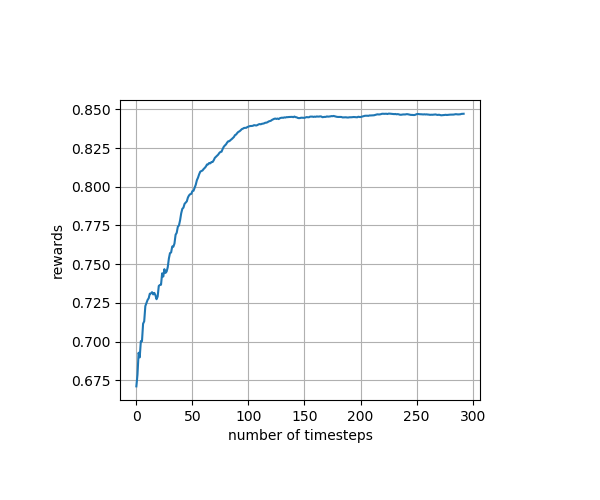

Using cuda device
seed 3: grid fidelity factor 0.25 learning ..
environement grid size (nx x ny ): 7 x 22


/data/ad181/RemoteDir/ada_multigrid_ppo/utils/custom_eval_callback.py:291: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fd63b7cd7b8> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fd608093828>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=2560, episode_reward=0.68 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
--------------------------------------
| eval/                   |          |
|    mean_ep_length       | 5        |
|    mean_reward          | 0.68     |
| time/                   |          |
|    fps                  | 163      |
|    iterations           | 1        |
|    time_elapsed         | 15       |
|    total_timesteps      | 2560     |
| train/                  |          |
|    approx_kl            | 0.159102 |
|    clip_fraction        | 0.657    |
|    clip_range           | 0.15     |
|    entropy_loss         | 15.9     |
|    explained_variance   | 0.994    |
|    learning_rate        | 0.0001   |
|    loss                 | 0.0362   |
|    n_updates            | 5860     |
|    policy_gradient_loss | 0.00156  |
|    std                  | 0.117    |
|    value_loss           | 0.000366 |
--------------------------------------
policy iteration runtime: 46 seconds

policy iteration runtime: 31 seconds

Total episode rollouts: 4096

Eval num_timesteps=2560, episode_reward=0.73 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.727       |
| time/                   |             |
|    fps                  | 734         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.033490755 |
|    clip_fraction        | 0.483       |
|    clip_range           | 0.15        |
|    entropy_loss         | 5.88        |
|    explained_variance   | 0.958       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0773     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0452     |
|    std                  | 

policy iteration runtime: 33 seconds

Total episode rollouts: 8192

Eval num_timesteps=2560, episode_reward=0.74 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.745      |
| time/                   |            |
|    fps                  | 725        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.04330797 |
|    clip_fraction        | 0.526      |
|    clip_range           | 0.15       |
|    entropy_loss         | 6.18       |
|    explained_variance   | 0.968      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0416    |
|    n_updates            | 320        |
|    policy_gradient_loss | -0.0437    |
|    std                  | 0.18       |
|    v

policy iteration runtime: 30 seconds

Total episode rollouts: 12288

Eval num_timesteps=2560, episode_reward=0.76 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.758       |
| time/                   |             |
|    fps                  | 770         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.062502824 |
|    clip_fraction        | 0.56        |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.49        |
|    explained_variance   | 0.97        |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0129      |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0442     |
|    std                  | 0.178       |
|    va

policy iteration runtime: 31 seconds

Total episode rollouts: 16384

Eval num_timesteps=2560, episode_reward=0.77 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.772       |
| time/                   |             |
|    fps                  | 738         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.061955355 |
|    clip_fraction        | 0.577       |
|    clip_range           | 0.15        |
|    entropy_loss         | 6.97        |
|    explained_variance   | 0.975       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0639     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0416     |
|    std                  |

policy iteration runtime: 34 seconds

Total episode rollouts: 20480

Eval num_timesteps=2560, episode_reward=0.78 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.781       |
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.078381255 |
|    clip_fraction        | 0.584       |
|    clip_range           | 0.15        |
|    entropy_loss         | 7.41        |
|    explained_variance   | 0.977       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0373     |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0344     |
|    std                  |

policy iteration runtime: 24 seconds

Total episode rollouts: 24576

Eval num_timesteps=2560, episode_reward=0.79 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.793       |
| time/                   |             |
|    fps                  | 776         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.085904405 |
|    clip_fraction        | 0.579       |
|    clip_range           | 0.15        |
|    entropy_loss         | 8.06        |
|    explained_variance   | 0.979       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.046      |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0326     |
|    std                  |

policy iteration runtime: 33 seconds

Total episode rollouts: 28672

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.805      |
| time/                   |            |
|    fps                  | 767        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07088951 |
|    clip_fraction        | 0.604      |
|    clip_range           | 0.15       |
|    entropy_loss         | 8.6        |
|    explained_variance   | 0.981      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0147    |
|    n_updates            | 1120       |
|    policy_gradient_loss | -0.0278    |
|    std                  | 0.162      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 32768

Eval num_timesteps=2560, episode_reward=0.81 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.814      |
| time/                   |            |
|    fps                  | 770        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08384001 |
|    clip_fraction        | 0.609      |
|    clip_range           | 0.15       |
|    entropy_loss         | 9.23       |
|    explained_variance   | 0.986      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0705    |
|    n_updates            | 1280       |
|    policy_gradient_loss | -0.0247    |
|    std                  | 0.157      |
|    

policy iteration runtime: 31 seconds

Total episode rollouts: 36864

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 5         |
|    mean_reward          | 0.819     |
| time/                   |           |
|    fps                  | 802       |
|    iterations           | 1         |
|    time_elapsed         | 3         |
|    total_timesteps      | 2560      |
| train/                  |           |
|    approx_kl            | 0.0770528 |
|    clip_fraction        | 0.614     |
|    clip_range           | 0.15      |
|    entropy_loss         | 9.98      |
|    explained_variance   | 0.987     |
|    learning_rate        | 0.0001    |
|    loss                 | -0.0441   |
|    n_updates            | 1440      |
|    policy_gradient_loss | -0.0225   |
|    std                  | 0.152     |
|    value_loss          

policy iteration runtime: 36 seconds

Total episode rollouts: 40960

Eval num_timesteps=2560, episode_reward=0.82 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.824      |
| time/                   |            |
|    fps                  | 788        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.07960223 |
|    clip_fraction        | 0.612      |
|    clip_range           | 0.15       |
|    entropy_loss         | 10.5       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0364    |
|    n_updates            | 1600       |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.149      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 45056

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.826      |
| time/                   |            |
|    fps                  | 783        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08220573 |
|    clip_fraction        | 0.609      |
|    clip_range           | 0.15       |
|    entropy_loss         | 11         |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.067     |
|    n_updates            | 1760       |
|    policy_gradient_loss | -0.0205    |
|    std                  | 0.146      |
|    value_loss           |

policy iteration runtime: 39 seconds

Total episode rollouts: 49152

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.828      |
| time/                   |            |
|    fps                  | 749        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09352454 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 11.6       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0606    |
|    n_updates            | 1920       |
|    policy_gradient_loss | -0.0175    |
|    std                  | 0.142      |
|    

policy iteration runtime: 33 seconds

Total episode rollouts: 53248

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.83       |
| time/                   |            |
|    fps                  | 779        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09478041 |
|    clip_fraction        | 0.629      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.1       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0215    |
|    n_updates            | 2080       |
|    policy_gradient_loss | -0.016     |
|    std                  | 0.139      |
|    

policy iteration runtime: 34 seconds

Total episode rollouts: 57344

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.831      |
| time/                   |            |
|    fps                  | 768        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09470548 |
|    clip_fraction        | 0.61       |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0602    |
|    n_updates            | 2240       |
|    policy_gradient_loss | -0.0118    |
|    std                  | 0.138      |
|    value_loss           |

policy iteration runtime: 37 seconds

Total episode rollouts: 61440

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 783        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.09234057 |
|    clip_fraction        | 0.618      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.5       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0286    |
|    n_updates            | 2400       |
|    policy_gradient_loss | -0.0102    |
|    std                  | 0.136      |
|    value_loss           |

policy iteration runtime: 41 seconds

Total episode rollouts: 65536

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.832      |
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08790326 |
|    clip_fraction        | 0.629      |
|    clip_range           | 0.15       |
|    entropy_loss         | 12.9       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0342     |
|    n_updates            | 2560       |
|    policy_gradient_loss | -0.0126    |
|    std                  | 0.133      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 69632

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 786        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11521058 |
|    clip_fraction        | 0.623      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.037      |
|    n_updates            | 2720       |
|    policy_gradient_loss | -0.0163    |
|    std                  | 0.132      |
|    

policy iteration runtime: 44 seconds

Total episode rollouts: 73728

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 747        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.08675532 |
|    clip_fraction        | 0.621      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.6       |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.029     |
|    n_updates            | 2880       |
|    policy_gradient_loss | -0.0105    |
|    std                  | 0.129      |
|    value_loss           |

policy iteration runtime: 32 seconds

Total episode rollouts: 77824

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.833      |
| time/                   |            |
|    fps                  | 823        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12151557 |
|    clip_fraction        | 0.645      |
|    clip_range           | 0.15       |
|    entropy_loss         | 13.9       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0519    |
|    n_updates            | 3040       |
|    policy_gradient_loss | -0.00952   |
|    std                  | 0.128      |
|    value_loss           |

policy iteration runtime: 30 seconds

Total episode rollouts: 81920

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 764        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.11407809 |
|    clip_fraction        | 0.642      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.2       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0123     |
|    n_updates            | 3200       |
|    policy_gradient_loss | -0.0134    |
|    std                  | 0.126      |
|    

policy iteration runtime: 32 seconds

Total episode rollouts: 86016

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.834      |
| time/                   |            |
|    fps                  | 774        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.10953295 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 14.5       |
|    explained_variance   | 0.994      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0389    |
|    n_updates            | 3360       |
|    policy_gradient_loss | -0.00926   |
|    std                  | 0.124      |
|    value_loss           |

policy iteration runtime: 31 seconds

Total episode rollouts: 90112

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.834       |
| time/                   |             |
|    fps                  | 821         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.116553366 |
|    clip_fraction        | 0.644       |
|    clip_range           | 0.15        |
|    entropy_loss         | 14.7        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0583     |
|    n_updates            | 3520        |
|    policy_gradient_loss | -0.0105     |
|    std                  | 0.123       |
|    va

policy iteration runtime: 32 seconds

Total episode rollouts: 94208

Eval num_timesteps=2560, episode_reward=0.83 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.835       |
| time/                   |             |
|    fps                  | 777         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.115875795 |
|    clip_fraction        | 0.662       |
|    clip_range           | 0.15        |
|    entropy_loss         | 15.1        |
|    explained_variance   | 0.992       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.0371     |
|    n_updates            | 3680        |
|    policy_gradient_loss | -0.0107     |
|    std                  |

policy iteration runtime: 29 seconds

Total episode rollouts: 98304

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 780        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12459042 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0552    |
|    n_updates            | 3840       |
|    policy_gradient_loss | -0.00951   |
|    std                  | 0.12       |
|    value_loss           |

policy iteration runtime: 29 seconds

Total episode rollouts: 102400

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 776        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12979588 |
|    clip_fraction        | 0.672      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.3       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0104    |
|    n_updates            | 4000       |
|    policy_gradient_loss | -0.0137    |
|    std                  | 0.119      |
|    value_loss           

policy iteration runtime: 29 seconds

Total episode rollouts: 106496

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 761        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12027087 |
|    clip_fraction        | 0.659      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.4       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0436    |
|    n_updates            | 4160       |
|    policy_gradient_loss | -0.00856   |
|    std                  | 0.119      |
|    value_loss           

Early stopping at step 13 due to reaching max kl: 0.15
policy iteration runtime: 22 seconds

Total episode rollouts: 110592

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 793        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15214412 |
|    clip_fraction        | 0.656      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.5       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0316    |
|    n_updates            | 4320       |
|    policy_gradient_loss | -0.00353   |
|    std    

policy iteration runtime: 30 seconds

Total episode rollouts: 114688

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
New best mean reward!
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 5           |
|    mean_reward          | 0.836       |
| time/                   |             |
|    fps                  | 784         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2560        |
| train/                  |             |
|    approx_kl            | 0.124437414 |
|    clip_fraction        | 0.671       |
|    clip_range           | 0.15        |
|    entropy_loss         | 15.8        |
|    explained_variance   | 0.993       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0707      |
|    n_updates            | 4480        |
|    policy_gradient_loss | -0.00916    |
|    std                  

policy iteration runtime: 24 seconds

Total episode rollouts: 118784

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 781        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14644878 |
|    clip_fraction        | 0.669      |
|    clip_range           | 0.15       |
|    entropy_loss         | 15.7       |
|    explained_variance   | 0.992      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00669   |
|    n_updates            | 4640       |
|    policy_gradient_loss | -0.013     |
|    std                  | 0.117      |
|    value_loss           

policy iteration runtime: 34 seconds

Total episode rollouts: 122880

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 787        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14400098 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16         |
|    explained_variance   | 0.993      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0525    |
|    n_updates            | 4800       |
|    policy_gradient_loss | -0.0112    |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 126976

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 771        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13358827 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0367    |
|    n_updates            | 4960       |
|    policy_gradient_loss | -0.00816   |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 34 seconds

Total episode rollouts: 131072

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.835      |
| time/                   |            |
|    fps                  | 783        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.14307526 |
|    clip_fraction        | 0.663      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.991      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0813    |
|    n_updates            | 5120       |
|    policy_gradient_loss | -0.0126    |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 34 seconds

Total episode rollouts: 135168

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 781        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.12789783 |
|    clip_fraction        | 0.662      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.1       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0323     |
|    n_updates            | 5280       |
|    policy_gradient_loss | -0.00784   |
|    std                  | 0.115      |
|    value_loss           

policy iteration runtime: 36 seconds

Total episode rollouts: 139264

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 808        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.13803552 |
|    clip_fraction        | 0.67       |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.2       |
|    explained_variance   | 0.99       |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0241     |
|    n_updates            | 5440       |
|    policy_gradient_loss | -0.0108    |
|    std                  | 0.114      |
|    value_loss           

Early stopping at step 15 due to reaching max kl: 0.15
policy iteration runtime: 24 seconds

Total episode rollouts: 143360

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 779        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15096274 |
|    clip_fraction        | 0.671      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.4       |
|    explained_variance   | 0.989      |
|    learning_rate        | 0.0001     |
|    loss                 | 0.0122     |
|    n_updates            | 5600       |
|    policy_gradient_loss | -0.00567   |
|    std    

Early stopping at step 14 due to reaching max kl: 0.15
policy iteration runtime: 19 seconds

Total episode rollouts: 147456

Eval num_timesteps=2560, episode_reward=0.84 +/- 0.00
Episode length: 5.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 5          |
|    mean_reward          | 0.836      |
| time/                   |            |
|    fps                  | 778        |
|    iterations           | 1          |
|    time_elapsed         | 3          |
|    total_timesteps      | 2560       |
| train/                  |            |
|    approx_kl            | 0.15174106 |
|    clip_fraction        | 0.665      |
|    clip_range           | 0.15       |
|    entropy_loss         | 16.5       |
|    explained_variance   | 0.988      |
|    learning_rate        | 0.0001     |
|    loss                 | -0.0713    |
|    n_updates            | 5760       |
|    policy_gradient_loss | -0.00345   |
|    std    

<IPython.core.display.Javascript object>


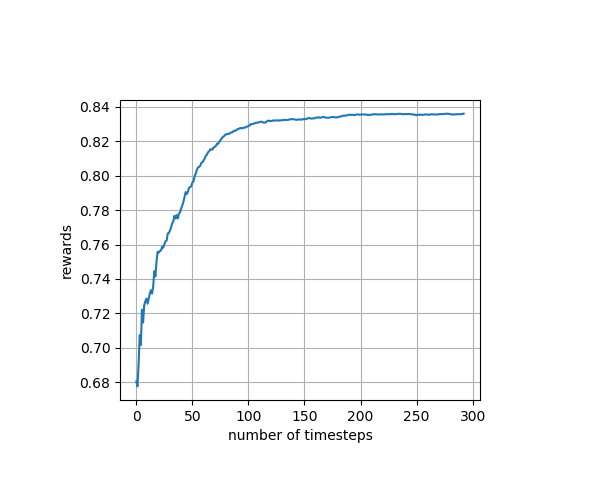

In [7]:
for seed in range(1,4):
    model = multigrid_framework(env_train, 
                                generate_model,
                                generate_callback, 
                                delta_pcent=0.3, 
                                n=np.inf,
                                grid_fidelity_factor_array =[0.25],
                                episode_limit_array=[150000], 
                                log_dir=log_dir,
                                seed=seed)